In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, balanced_accuracy_score
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import RocCurveDisplay

Data loading and cleaning

In [2]:
X_train = pd.read_csv("X_train.csv")
y_train = pd.read_csv("y_train.csv")

y_train['RiskPerformance'] = y_train['RiskPerformance'].map({'Bad': 1, 'Good': 0})
X_train[X_train < 0] = np.nan

y_train = y_train.sort_values(by='Unnamed: 0')
X_train = X_train.sort_values(by = 'Unnamed: 0')

X_ids = X_train.iloc[:, 0]
Y_ids = y_train.iloc[:, 0] 

X_train = X_train.drop(X_train.columns[0], axis=1)
y_train = y_train.drop(y_train.columns[0], axis=1)
mask = ~X_train.isnull().all(axis=1)

X_train = X_train[mask]
    
y_train = y_train[mask]
x10_mapping = {
    0: 'off scale',
    1: '120+ days overdue',
    2: '90 days overdue',
    3: '60 days overdue',
    4: '30 days overdue',
    5: 'unknown overdue',
    6: 'unknown overdue',
    7: 'current and never overdue',
    8: 'all others',
    9: 'all others'
}

x11_mapping = {
    1: 'no such value',
    2: 'off scale',
    3: '120+ days overdue',
    4: '90 days overdue',
    5: '60 days overdue',
    6: '30 days overdue',
    7: 'unknown overdue',
    8: 'current and never overdue',
    9: 'all others'
}

X_train['X10_categorical'] = X_train['X10'].map(x10_mapping)
X_train['X11_categorical'] = X_train['X11'].map(x11_mapping)
X_train = pd.get_dummies(X_train, columns=['X10_categorical', 'X11_categorical'], prefix=['X10', 'X11'])

X_train = X_train.drop(['X10', 'X11'], axis = 1)
X_train1, X_test1, y_train1, y_test1 = train_test_split(X_train, y_train, test_size = 0.3)


knn_imputer = KNNImputer(n_neighbors=3)
X_train1 = knn_imputer.fit_transform(X_train1)

# Convert back to DataFrame with original column names
X_train1 = pd.DataFrame(X_train1, columns=X_train.columns)

# Apply KNN Imputer to X_test1 and ensure feature names are preserved
X_test1 = knn_imputer.transform(X_test1)
X_test1 = pd.DataFrame(X_test1, columns=X_train.columns)  # Match feature names


Loading previously created models from pkl file

In [3]:
import joblib

# Load models
models = joblib.load("trained_models.pkl")

# Access models
lr = models["lr"]
svm = models["svm"]
nb = models["nb"]
lda = models["lda"]
qda = models["qda"]
tree = models["tree"]
knn = models["knn"]
rf = models["rf"]
et = models["et"]
gb = models["gb"]
stacking = models["stacking"]

print("Models loaded successfully!")


Models loaded successfully!


In [4]:
predictions_train = {}
predictions_test = {}
models_name = ["Logistic Regression", "SVM","Naive Bayes", "LDA", "QDA", "Binary Tree", "KNN", "Random Forest", "Extra Trees", "Gradient Boosting", "Stacking"]
for model_name, model in models.items():
    predictions_train[model_name] = model.predict(X_train1)
    predictions_test[model_name] = model.predict(X_test1)

Gathering all metrics in data frame

In [5]:
ba_train = []
ba_test = []
acc_train = []
acc_test = []
recall_train = []
recall_test = []
f1_test = []
f1_train = []
precision_test = []
precision_train = []

for model_name, model in models.items():
    ba_train.append(balanced_accuracy_score(y_train1["RiskPerformance"], predictions_train[model_name]))
    ba_test.append(balanced_accuracy_score(y_test1["RiskPerformance"], predictions_test[model_name]))
    acc_train.append(accuracy_score(y_train1["RiskPerformance"], predictions_train[model_name]))
    acc_test.append(accuracy_score(y_test1["RiskPerformance"], predictions_test[model_name]))
    recall_train.append(recall_score(y_train1["RiskPerformance"], predictions_train[model_name]))
    recall_test.append(recall_score(y_test1["RiskPerformance"], predictions_test[model_name]))
    f1_train.append(f1_score(y_train1["RiskPerformance"], predictions_train[model_name]))
    f1_test.append(f1_score(y_test1["RiskPerformance"], predictions_test[model_name]))
    precision_train.append(precision_score(y_train1["RiskPerformance"], predictions_train[model_name]))
    precision_test.append(precision_score(y_test1["RiskPerformance"], predictions_test[model_name]))
    

In [103]:
#Wyniki zapisuje w tabelce

results = pd.DataFrame({'model' : models_name,
                        'ba_train' : ba_train,
                        'ba_test' : ba_test,
                        'acc_train': acc_train,
                        'acc_test': acc_test,
                        'recall_train': recall_train,
                        'recall_test': recall_test,
                        'f1_train': f1_train,
                        'f1_test': f1_test,
                        'precision_test': precision_test,
                        'precision_train': precision_train})


In [105]:
results

,model,ba_train,ba_test,acc_train,acc_test,recall_train,recall_test,f1_train,f1_test,precision_test,precision_train
0,Logistic Regression,0.734939,0.733130,0.736255,0.734104,0.760818,0.769231,0.751944,0.748175,0.728242,0.743274
1,SVM,0.757826,0.763043,0.758578,0.763969,0.772620,0.797373,0.770801,0.776256,0.756228,0.768990
2,Naive Bayes,0.677433,0.685854,0.670112,0.682081,0.533438,0.545966,0.629526,0.638158,0.767810,0.767837
3,LDA,0.734236,0.729326,0.735428,0.730250,0.757671,0.763602,0.750585,0.744059,0.725490,0.743629
4,QDA,0.642183,0.643223,0.631253,0.637765,0.427223,0.440901,0.549039,0.555556,0.750799,0.768034
5,Binary Tree,0.747260,0.745167,0.747830,0.745665,0.758458,0.763602,0.759653,0.755102,0.746789,0.760852
6,KNN,0.867259,0.870342,0.866887,0.869942,0.859953,0.855535,0.871611,0.871060,0.887160,0.883589
7,Random Forest,0.808011,0.799731,0.809012,0.800578,0.827695,0.831144,0.819953,0.810613,0.791071,0.812355
8,Extra Trees,0.893026,0.894680,0.893344,0.894990,0.899292,0.906191,0.898585,0.898605,0.891144,0.897879
9,Gradient Boosting,0.763165,0.757207,0.764365,0.758189,0.786782,0.793621,0.778210,0.771194,0.750000,0.769823


Plotting all the basic metrics on both train and test set

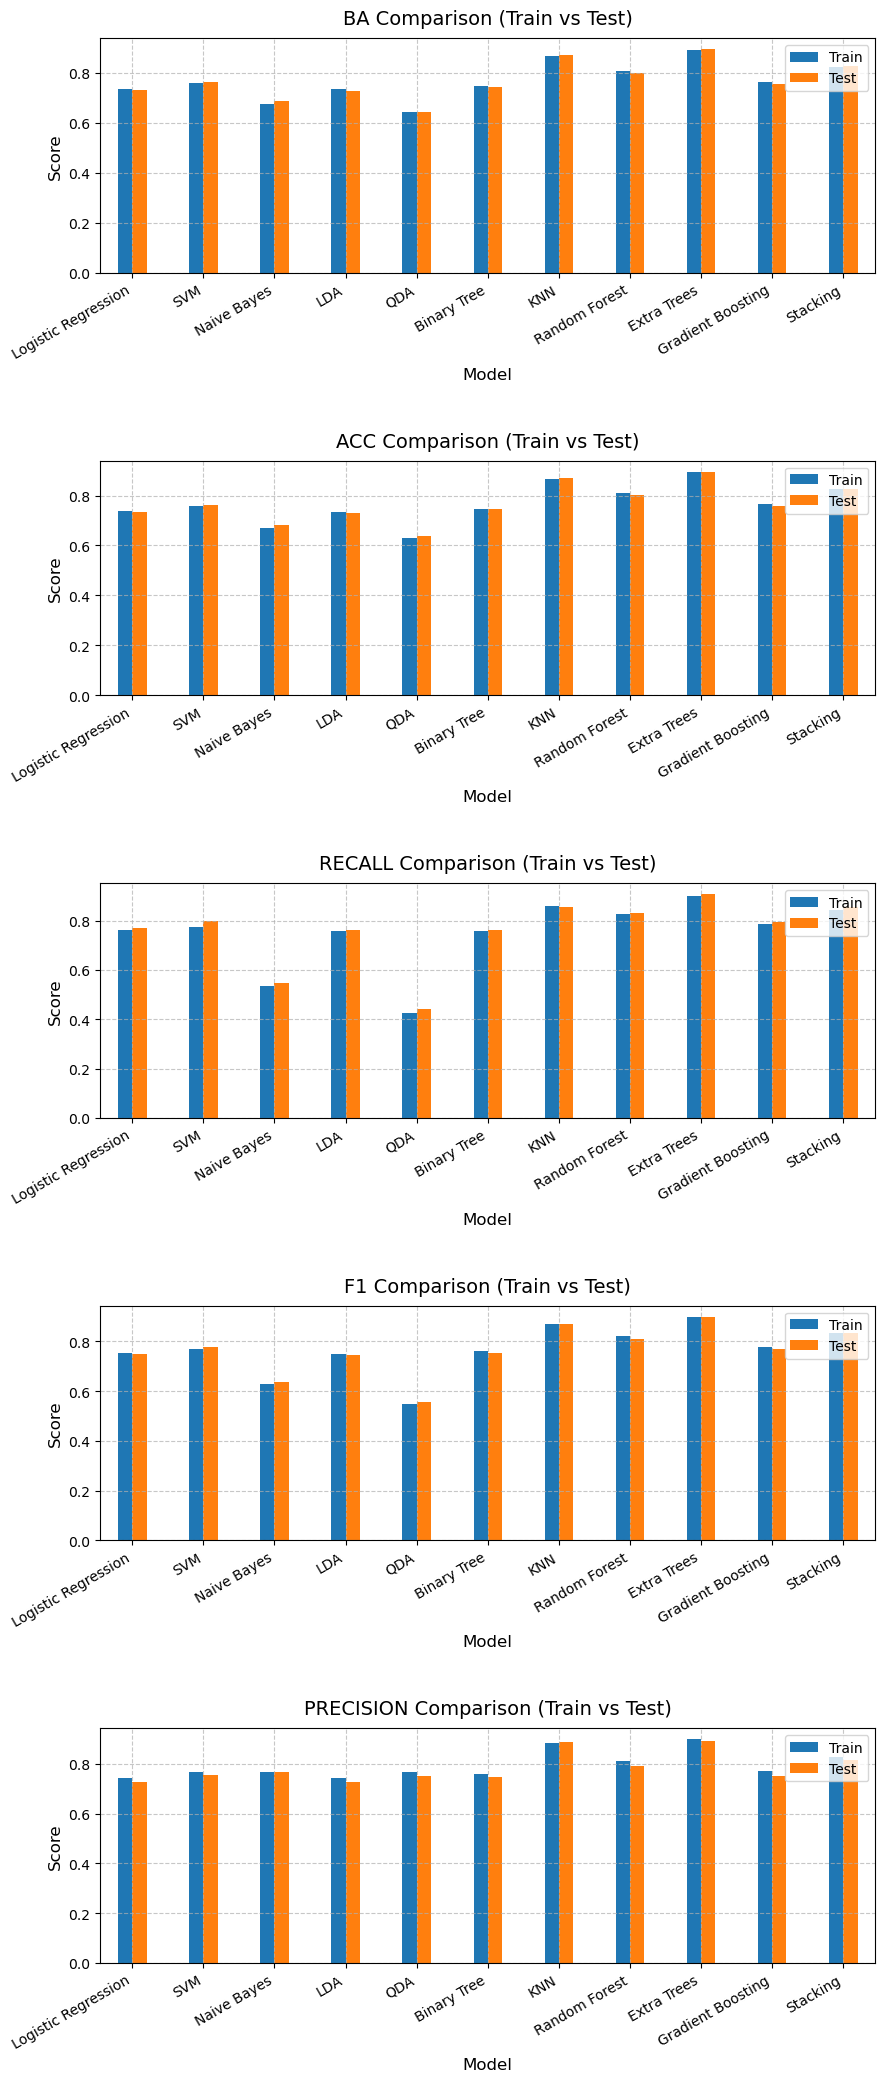

In [107]:
metrics = ['ba', 'acc', 'recall', 'f1', 'precision']

fig, axes = plt.subplots(nrows=len(metrics), figsize=(10, 5 * len(metrics)))
plt.subplots_adjust(hspace=0.8)  # Increase spacing between subplots

for i, metric in enumerate(metrics):
    ax = axes[i]
    df_plot = results[['model', f'{metric}_train', f'{metric}_test']].set_index('model')
    df_plot.plot(kind='bar', ax=ax, width=0.4)  # Reduce width for better separation
    ax.set_title(f"{metric.upper()} Comparison (Train vs Test)", fontsize=14, pad=10)
    ax.set_ylabel("Score", fontsize=12)
    ax.set_xlabel("Model", fontsize=12)
    ax.set_xticklabels(df_plot.index, rotation=30, ha="right", fontsize=10)
    ax.legend(["Train", "Test"], loc="upper right")

    ax.grid(True, linestyle='--', alpha=0.7)

plt.show()


Plotting all the ROC curves on one plot

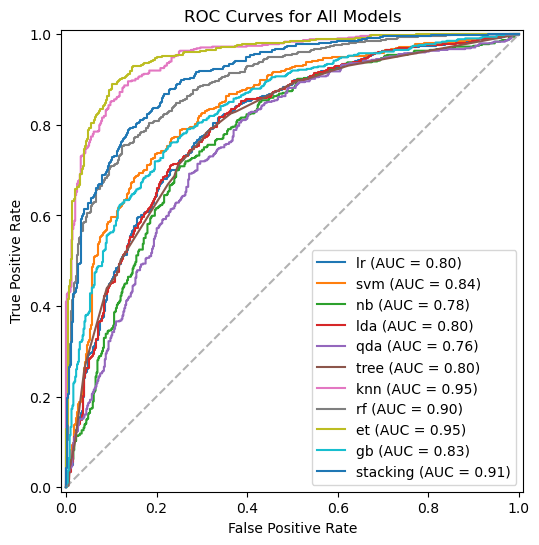

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

for name, model in models.items():
    RocCurveDisplay.from_estimator(model, X_test1, y_test1, name=name, ax=ax)

plt.title("ROC Curves for All Models")
plt.plot([0, 1], [0, 1], linestyle="--", color="grey", alpha=0.6) 
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")


plt.show()

As a final model i am choosing extra trees. It has relatively good metrics on test set and it's ROC curve has the best shape.